# Import package and dataset

In [1]:
!pip install mat73
import mat73
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import sys
import random
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy.linalg as LA
import os
import math
import time
import torch.nn.functional as F
from scipy.interpolate import Rbf
from scipy import interpolate
from torch.utils.tensorboard import SummaryWriter
import scipy.io as sio
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import logging

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
# !gdown 17FfAoAsvEhTFaQXB97xoVVKN4rDeBE41
# !gdown 1b4Z_ngrkzTxZ1U1bWqCfE9gERvRZCYqq

# !unzip '/content/Train_144.mat.zip'
# !unzip '/content/Test_144.mat.zip'
# !mkdir 'test'
# !mkdir 'train'
# !mv '/content/Test_144.mat' '/content/test/Test_144.mat'
# !mv '/content/Train_144.mat' '/content/train/Train_144.mat'

In [2]:
################## CDL- Custom 16*144 ##############################
!gdown 1TNjUt9JA5dRZRvnxu2a8FlzQEvnivpTd
!gdown 1JLbwZk4QvM0c1MiDaHY6wztqKjslsP02

!mkdir 'test'
!mkdir 'train'

!mv '/content/Test144.mat' '/content/test/Test144.mat'
!mv '/content/Train144.mat' '/content/train/Train144.mat'

Downloading...
From (original): https://drive.google.com/uc?id=1TNjUt9JA5dRZRvnxu2a8FlzQEvnivpTd
From (redirected): https://drive.google.com/uc?id=1TNjUt9JA5dRZRvnxu2a8FlzQEvnivpTd&confirm=t&uuid=62b14b53-bc48-4bab-9df3-77e29cd363a9
To: /content/Train144.mat
100% 1.42G/1.42G [00:20<00:00, 68.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1JLbwZk4QvM0c1MiDaHY6wztqKjslsP02
From (redirected): https://drive.google.com/uc?id=1JLbwZk4QvM0c1MiDaHY6wztqKjslsP02&confirm=t&uuid=a763070a-b452-4150-a3c3-acc9bd5f62dd
To: /content/Test144.mat
100% 355M/355M [00:04<00:00, 83.3MB/s]


# LS Preprocessing

In [3]:
# DFT matrix
def DFT_matrix(N):
    m, n = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1j / N )
    D = np.power( omega, m * n )
    return D

## Some parameters

In [4]:
M_t = 144
Nt = 16
M = 144
ch = 2

snr = 20
SNR=10.0**(snr/10.0) # transmit power

# linear_spaced_array = np.linspace(0, M, M_t+1)
# IRS_index = np.round(linear_spaced_array).astype(int)
# print(IRS_index[:-1])
IRS_index = range(0,M,1)

PHI = np.zeros((M,M_t), dtype=complex)
PHI_t = DFT_matrix(len(IRS_index))

for c in range(M_t):
  index = IRS_index[c]
  for i in range(M_t):
    PHI[index,i]=PHI_t[c,i]
print(M_t)
print(len(IRS_index))

phi = np.dot(PHI,np.transpose(np.conjugate(PHI)))

144
144


## Preprocessing on Train datas

In [5]:
############## training set generation ##################
file_dir = '/content/train'

data_num_train = 2000
data_num_file = 2000
Y=np.zeros((Nt,M_t), dtype=float)
H_train=np.zeros((data_num_train,Nt,M,ch), dtype=float)
H_train_noisy=np.zeros((data_num_train,Nt,M,ch), dtype=float)
filedir = os.listdir(file_dir)  # type the path of training data

SNRr = 0

for filename in filedir:
    newname = os.path.join(file_dir, filename)
    data = mat73.loadmat(newname)
    channel = data['H']
    data = []
    for i in range(data_num_file):
        # H = np.sqrt(2304/74)*channel[:,:,i]
        # H = np.sqrt(4.5232e+08)*channel[:,:,i]
        H = np.sqrt(143.4916)*channel[:,:,i]
        H_re = np.real(H)
        H_im = np.imag(H)

        H_train[i, :, :, 0] = H_re
        H_train[i, :, :, 1] = H_im

        N = np.random.normal(0, 1 / np.sqrt(2), size=(Nt, M)) + 1j * np.random.normal(0, 1 / np.sqrt(2), size=(Nt, M))
        N_hat = np.dot(N,phi)

        H_hat = np.dot(H,phi)
        Y = H_hat + (1.0/SNR) * N_hat
        H_hat_re = np.real(Y)
        H_hat_im = np.imag(Y)

        SNRr = SNRr + SNR * (LA.norm(H_hat)) ** 2 / (LA.norm(N_hat)) ** 2

        H_train_noisy[i, :, :, 0] = H_hat_re
        H_train_noisy[i, :, :, 1] = H_hat_im

print(SNRr/(data_num_train))
SNRR = 10 * np.log10(SNRr/(data_num_train))
print(SNRR)
print(H_train.shape,H_train_noisy.shape)
channel = []

99.58120506114146
19.981773774951492
(2000, 16, 144, 2) (2000, 16, 144, 2)


## Preprocessing on test datas

In [6]:
############## training set generation ##################
file_dir_test = '/content/test'

data_num_test = 500
data_num_file = 500
Y=np.zeros((Nt,M), dtype=float)
H_test=np.zeros((data_num_test,Nt,M,ch), dtype=float)
H_test_noisy=np.zeros((data_num_test,Nt,M,ch), dtype=float)
filedir = os.listdir(file_dir_test)  # type the path of training data

SNRr = 0

for filename in filedir:
    newname = os.path.join(file_dir_test, filename)
    data = mat73.loadmat(newname)
    # data = sio.loadmat(newname)
    channel = data['H']
    for i in range(data_num_test):
        # H = np.sqrt(2304/74)*channel[:,:,i]
        # H = np.sqrt(4.5232e+08)*channel[:,:,i]
        H = np.sqrt(144.0692)*channel[:,:,i]

        H_re = np.real(H)
        H_im = np.imag(H)

        H_test[i, :, :, 0] = H_re
        H_test[i, :, :, 1] = H_im

        N = np.random.normal(0, 1 / np.sqrt(2), size=(Nt, M)) + 1j * np.random.normal(0, 1 / np.sqrt(2), size=(Nt, M))

        N_hat = np.dot(N,phi)
        H_hat = np.dot(H,phi)

        Y = H_hat + (1.0/SNR) * N_hat
        H_hat_re = np.real(Y)
        H_hat_im = np.imag(Y)

        SNRr = SNRr + SNR * (LA.norm(H_hat)) ** 2 / (LA.norm(N_hat)) ** 2

        H_test_noisy[i, :, : ,0] = H_hat_re
        H_test_noisy[i, :, :, 1] = H_hat_im

print(SNRr/(data_num_test))
SNRR = 10 * np.log10(SNRr/(data_num_test))
print(SNRR)
print(H_test.shape,H_test_noisy.shape)

99.85376893723786
19.993644617731107
(500, 16, 144, 2) (500, 16, 144, 2)


# Dataset

In [7]:
class mydataset(Dataset):
  def __init__(self , datas , labels):
    super(mydataset,self).__init__()
    self.datas = torch.tensor(datas , dtype=torch.float)
    self.datas = torch.permute(self.datas, (0,3,1,2)) # must to use torch.permute beacuse the channel must be after batch size [batch_size , channel , nr , nt]

    self.labels = torch.tensor(labels , dtype=torch.float)
    self.labels = torch.permute(self.labels, (0,3,1,2)) #  must to use torch.permute beacuse the channel must be after batch size [batch_size , channel , nr , nt]
  def __getitem__(self, index):
    return self.datas[index] , self.labels[index]
  def __len__(self):
    return self.datas.shape[0]

In [8]:
batch_size = 64
batch_test = 64

trainset = mydataset(H_train_noisy , H_train)
trainloader = DataLoader(trainset , batch_size = batch_size , shuffle = True, drop_last=True)

testset = mydataset(H_test_noisy , H_test)
testloader = DataLoader(testset , batch_size = batch_test , shuffle = False, drop_last=True)

def test_DnCNN(testloader,model):
  nmse = np.zeros((1000,1))
  k = 0
  model.eval()
  for (input,label) in tqdm(testloader):
    nmse2=torch.zeros((batch_test,1), dtype=torch.float16)

    input,label = input.to(device),label.to(device)
    decoded_channel = model(input)

    for n in range(batch_test):
        MSE=((label[n,:,:,:]-decoded_channel[n,:,:,:])**2).sum()
        norm_real=((label[n,:,:,:])**2).sum()
        nmse2[n]=MSE/norm_real

    a = nmse2.sum()
    nmse[k] = a.detach().numpy()
    k = k + 1

  return nmse


In [9]:
def test_SrCNN(testloader,model):
  nmse = np.zeros((1000,1))
  k = 0
  dn_model.eval()
  model.eval()
  for (input,label) in tqdm(testloader):
    nmse2=torch.zeros((batch_test,1), dtype=torch.float16)

    input,label = input.to(device),label.to(device)
    input2 = dn_model(input)
    decoded_channel = model(input2)

    for n in range(batch_test):
        MSE=((label[n,:,:,:]-decoded_channel[n,:,:,:])**2).sum()
        norm_real=((label[n,:,:,:])**2).sum()
        nmse2[n]=MSE/norm_real

    a = nmse2.sum()
    nmse[k] = a.detach().numpy()
    k = k + 1

  return nmse

In [10]:
H_train_noisy =[]
H_train = []
H_test_noisy =[]
H_test = []
data = []
channel = []

# **Convolutional Attention Network (CAN)**

## MBconv

In [11]:
class MBconv1(nn.Module):
    def __init__(self,channel):
      super(MBconv1, self).__init__()
      self.channel = channel
      self.Conv2dNormActivation1 = nn.Sequential(
          nn.Conv2d(in_channels= channel*2, out_channels= channel*2, kernel_size=3 , stride=1 , padding=1 , groups=channel*2),
          nn.BatchNorm2d(channel*2),
          nn.SiLU()
      )
      self.SqueezeExcitation = nn.Sequential(
          nn.Conv2d(in_channels = channel*2 , out_channels = channel//2 , kernel_size= 1, stride= 1),
          nn.Conv2d(in_channels = channel//2 , out_channels = channel*2 , kernel_size=1 , stride= 1),
          nn.SiLU(),
      )
      self.Conv2dNormActivation2 = nn.Sequential(
          nn.Conv2d(in_channels=channel*2 , out_channels=channel , kernel_size=1 , stride=1 ,padding=1),
          nn.BatchNorm2d(channel ,eps=0.001 , momentum=0.01),
      )


    def forward(self, x):
      x1 = self.Conv2dNormActivation1(x)
      x1 = x1+x
      x2 = self.SqueezeExcitation(x1)
      x2 = x2+x1
      x3 = self.Conv2dNormActivation2(x2)
      return x3

## Attention block

In [12]:
class AttentionBlock(nn.Module):
  def __init__(self, in_channels):
    super(AttentionBlock, self).__init__()
    self.conv_query = MBconv1(16)
    self.conv_key = MBconv1(16)
    self.conv_value = MBconv1(16)
    self.conv_out = nn.Conv2d(16, 32, kernel_size=3)

  def forward(self, x):
    query = self.conv_query(x)
    key = self.conv_key(x)
    value = self.conv_value(x)

    # Apply channel scaling for stability
    d_k = query.size(1)
    attention = F.softmax(torch.einsum('bchw, bkhw -> bchw', query, key) / d_k, dim=1)
    context = torch.einsum('bchw, bchw -> bchw', attention, value)
    out = self.conv_out(context)
    return out

## MB-Attention model

In [16]:
class DenoisingNetwork(nn.Module):
  def __init__(self, in_channels):
    super(DenoisingNetwork, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=2, padding=1)
    self.attn1 = AttentionBlock(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=2)
    self.attn2 = AttentionBlock(32)
    self.conv3 = nn.Conv2d(32, in_channels, kernel_size=1)

  def forward(self, x):
    x1 = self.conv1(x)
    x1 = F.relu(x1)
    x2 = self.attn1(x1)
    x2 = x1+x2

    x2 = F.relu(self.conv2(x2))

    x3 = self.attn2(x2)
    x3 = x3+x2
    # x3 = F.relu(x3)

    x3 = self.conv3(x3)
    # x3 = self.dnCnn(x3)
    return x - x3


In [17]:
dn_model = DenoisingNetwork(2).to(device)
x = torch.rand(64,2,Nt,M).to(device)
dn_model(x).shape

torch.Size([64, 2, 16, 144])

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The gen has {count_parameters(dn_model):,} trainable parameters')


The gen has 22,738 trainable parameters


# Default setting

In [19]:
optimizer_dn = torch.optim.Adam(dn_model.parameters(),lr=0.0002, betas=(0.9, 0.999))
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer_dn, T_max=800)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optimizer_dn , step_size = 100 , gamma=0.6)
criterion = nn.MSELoss()

logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger('MBA: ')

In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Training function

In [21]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # # If we don't do this then it will just have learning rate of old checkpoint
    # # and it will lead to many hours of debugging \:
    # for param_group in optimizer.param_groups:
    #     param_group["lr"] = lr

In [22]:
train_loss=[]
def train_network2(train_loader):
  total_loss = AverageMeter()
  dn_model.train()
  for (x, labels) in tqdm(train_loader): #for each batch calculate something for 1 epoch.
    x, labels = x.to(device) , labels.to(device)
    outputs = dn_model(x)
    loss = criterion(outputs, labels) #loss between out and lables
    optimizer_dn.zero_grad() #befor use next line better to use zero.grad( )
    loss.backward()
    optimizer_dn.step()
    total_loss.update(loss)
    # lr_scheduler.step()
  train_loss.append(total_loss.avg.cpu().detach().numpy() )
  # logger.info(f'Train: Epoch:{epoch} \t Loss:{total_loss.avg:.4} ')
  logger.info(f'Train: Epoch:{epoch} \t Loss:{total_loss.avg:.4} \t lr:{lr_scheduler.get_last_lr()}')
  if epoch == end-1:
    torch.save(dn_model,'MB_Attention.pth')
    print('\n Model saving ... \n')

  return

# Training

In [ ]:
# load_model= '/content/MBA_epoch_250.pth.tar'
# load_checkpoint(load_model,dn_model,optimizer_dn,0.0002)

In [23]:
NMSE_test = []
start , end = 1 , 211
for epoch in range (start , end):
  train_network2( trainloader )
  nmse_test = test_DnCNN(testloader,dn_model)
  c = nmse_test.sum()/data_num_test
  NMSE_test.append(c)
  print('NMSE_test = {}'.format(c))
  lr_scheduler.step()
  print('--------------------------------------------------------------')
  if epoch >= 51 and epoch%5==0:
    plt.plot(NMSE_test[50:-1])
    plt.show()
    print(np.min(NMSE_test))

100%|██████████| 31/31 [00:02<00:00, 13.31it/s]
INFO:MBA: :Train: Epoch:1 	 Loss:9.713e+03 	 lr:[0.0002]
100%|██████████| 7/7 [00:00<00:00, 26.32it/s]


NMSE_test = inf
--------------------------------------------------------------


100%|██████████| 31/31 [00:01<00:00, 17.54it/s]
INFO:MBA: :Train: Epoch:2 	 Loss:6.931e+03 	 lr:[0.0002]
100%|██████████| 7/7 [00:00<00:00, 31.82it/s]


NMSE_test = inf
--------------------------------------------------------------


100%|██████████| 31/31 [00:01<00:00, 17.57it/s]
INFO:MBA: :Train: Epoch:3 	 Loss:3.95e+03 	 lr:[0.0002]
100%|██████████| 7/7 [00:00<00:00, 31.35it/s]


NMSE_test = inf
--------------------------------------------------------------


100%|██████████| 31/31 [00:01<00:00, 17.49it/s]
INFO:MBA: :Train: Epoch:4 	 Loss:1.56e+03 	 lr:[0.0002]
100%|██████████| 7/7 [00:00<00:00, 31.59it/s]


NMSE_test = inf
--------------------------------------------------------------


100%|██████████| 31/31 [00:01<00:00, 17.42it/s]
INFO:MBA: :Train: Epoch:5 	 Loss:439.5 	 lr:[0.0002]
100%|██████████| 7/7 [00:00<00:00, 28.77it/s]


NMSE_test = 374.656
--------------------------------------------------------------


 90%|█████████ | 28/31 [00:01<00:00, 16.60it/s]


KeyboardInterrupt: 

374.656


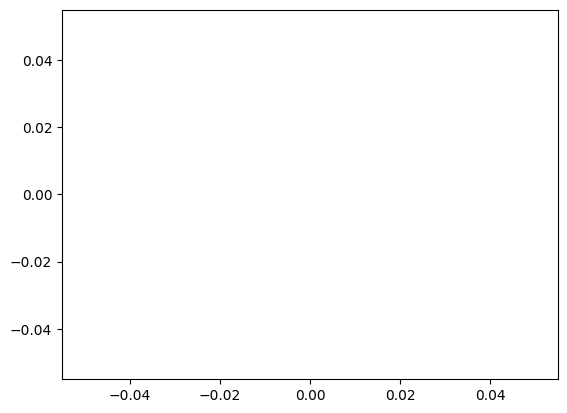

In [24]:
print(np.min(NMSE_test))
plt.plot(NMSE_test[1:-1])
plt.show()

# **Complex Multi-Convolutional Network (CMN)**

## Conv Block

In [25]:
class convblock(nn.Module):
    def __init__(self):
        super(convblock, self).__init__()

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
        )
    def forward(self, x):
      x2 = self.conv2(x)
      x2 = x2+x
      return x2



## Res-Net

In [26]:
class SRblock(nn.Module):
    def __init__(self, ch_in,num_blocks):
        super(SRblock, self).__init__()
        self.ch_in = ch_in
        self.num_blocks = num_blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=ch_in,out_channels=64,kernel_size=2),
            nn.PReLU(),
        )
        blocks=[]
        for i in range(num_blocks):
            blocks.append(
                convblock()
                )
        self.convBLOCK = nn.Sequential(*blocks)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
        )
        self.conv4 = nn.Conv2d(in_channels=64,out_channels=2,kernel_size=2,stride=1,padding=1)

    def forward(self, x):
      x1 = self.conv1(x)
      # print(x1.shape)
      x2 = self.convBLOCK(x1)
      # print(x2.shape)
      x3 = self.conv3(x2)
      x3 = x3+x1
      out = self.conv4(x3)
      return out



In [28]:
x = torch.rand(64,2,16,144).to(device)
sr_model = SRblock(2,4).to(device)
sr_model(x).shape

torch.Size([64, 2, 16, 144])

# Training Function

In [29]:
optimizer_sr = torch.optim.Adam(sr_model.parameters(),lr=0.0001, betas=(0.9, 0.999), eps=1e-8)
criterion = nn.MSELoss()

In [30]:
train_loss=[]
def train_network(model, train_loader):
  total_loss = AverageMeter()
  model.train()
  dn_model.eval()
  for (x, labels) in tqdm(train_loader): #for each batch calculate something for 1 epoch.
    x, labels = x.to(device) , labels.to(device)
    out = dn_model(x)
    outputs = model(out)
    loss = criterion(outputs, labels) #loss between out and lables
    optimizer_sr.zero_grad() #befor use next line better to use zero.grad( )
    loss.backward()
    optimizer_sr.step()
    total_loss.update(loss)
  train_loss.append(total_loss.avg.cpu().detach().numpy() )
  logger.info(f'Train: Epoch:{epoch} \t Loss:{total_loss.avg:.4}')
  if epoch == end-1:
   torch.save(sr_model,'SR_CNN.pth')
   print('\n \t\t\t\t\t\t\t\tModel saving ... \n')

  return

# Training phase

In [31]:
NMSE_test = []
start , end = 1 , 401
for epoch in range (start , end):
  train_network(sr_model , trainloader )
  nmse_test = test_SrCNN(testloader,sr_model)
  c = nmse_test.sum()/data_num_test
  NMSE_test.append(c)
  print('NMSE_test = {}'.format(c))
  print('--------------------------------------------------------------')
  if epoch%5==0:
    plt.plot(NMSE_test)
    plt.show()
    print(np.min(NMSE_test))

100%|██████████| 31/31 [00:04<00:00,  6.82it/s]
INFO:MBA: :Train: Epoch:1 	 Loss:1.508
100%|██████████| 7/7 [00:00<00:00, 15.99it/s]


NMSE_test = 0.858125
--------------------------------------------------------------


100%|██████████| 31/31 [00:04<00:00,  6.85it/s]
INFO:MBA: :Train: Epoch:2 	 Loss:0.277
100%|██████████| 7/7 [00:00<00:00, 12.32it/s]


NMSE_test = 0.3399375
--------------------------------------------------------------


100%|██████████| 31/31 [00:04<00:00,  6.77it/s]
INFO:MBA: :Train: Epoch:3 	 Loss:0.1407
100%|██████████| 7/7 [00:00<00:00, 15.67it/s]


NMSE_test = 0.210421875
--------------------------------------------------------------


 45%|████▌     | 14/31 [00:02<00:02,  6.61it/s]


KeyboardInterrupt: 

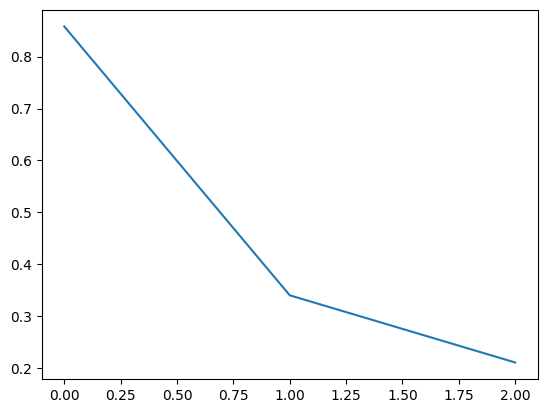

np.float64(0.210421875)

In [32]:
plt.plot(NMSE_test)
plt.show()
np.min(NMSE_test)

In [33]:
H_test=(torch.permute(torch.tensor(H_test , dtype = torch.float32),(0,3,1,2))).to(device)
H_test_noisy=torch.permute(torch.tensor(H_test_noisy,dtype = torch.float32),(0,3,1,2)).to(device)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 4

In [34]:
H_test_noisy.shape[0]

AttributeError: 'list' object has no attribute 'shape'

In [35]:
import time
# t1=time.time()
# dn_model.eval()
dn_model.eval()
t1=time.time()
decoded_channel = sr_model(H_test_noisy)
t2=time.time()
# decoded_channel = dn_model(H_test_interpolated)
t2=time.time()
# nmse2=torch.zeros((data_num_test,1), dtype=torch.float16)
# for n in range(data_num_test):
#     MSE=((H_train[n,:,:,:]-decoded_channel[n,:,:,:])**2).sum()
#     norm_real=((H_train[n,:,:,:])**2).sum()
#     nmse2[n]=MSE/norm_real
# print('NMSE = ',nmse2.sum()/(data_num_test))  # calculate NMSE after training stage (testing performance)
total_time = t2-t1
total_time = total_time/(H_test_noisy.shape[0])
print('t2-t1 = ',t2-t1)

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of []!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of []!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


In [ ]:
batch_test=10
testset = mydataset(H_test_noisy , H_test)
testloader = DataLoader(testset , batch_size = batch_test , shuffle = False, drop_last=True)

def test(testloader,model):
  nmse=np.zeros((1000,1), dtype=float16)
  k = 0
  model.eval()
  for (input,label) in tqdm(testloader):
    nmse2=torch.zeros((batch_test,1), dtype=torch.float16)

    input,label = input.to(device),label.to(device)
    t1=time.time()
    decoded_channel = dn_model(input)
    t2=time.time()

    for n in range(batch_test):
        MSE=((label[n,:,:,:]-decoded_channel[n,:,:,:])**2).sum()
        norm_real=((label[n,:,:,:])**2).sum()
        nmse2[n]=MSE/norm_real

    a = nmse2.sum()
    nmse[k] = a.detach().numpy()
    k = k + 1

  return nmse